# Notebook 10: Data Scale Experiment

**Research Question:** How do the number of seasons and players affect model performance?

**Configurations to test:**
- **BASE**: 3 seasons (2022-25), 120 players (~24K games)
- **EXP1**: 4 seasons (2021-25), 120 players (~32K games)
- **EXP2**: 5 seasons (2020-25), 120 players (~40K games)
- **EXP3**: 3 seasons (2022-25), 200 players (~40K games)
- **EXP4**: 3 seasons (2022-25), 300 players (~60K games)
- **EXP5**: 4 seasons (2021-25), 200 players (~53K games)
- **EXP6**: 5 seasons (2020-25), 200 players (~66K games)

**Goals:**
1. Determine if more historical data improves predictions
2. Determine if including more players improves generalization
3. Find optimal data configuration for production

## 1. Setup and Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import time
from datetime import datetime
import json
from tqdm import tqdm
import warnings
import logging
import random
warnings.filterwarnings('ignore')

# Set global random seeds for reproducibility
RANDOM_SEED = 42

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# Configure notebook logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)
logger = logging.getLogger('data_scale_experiment')

# Import our pipeline functions
import sys
sys.path.append('../')
from src.features.build_features import add_rolling_features, create_train_val_test_splits, clean_data, get_feature_lists
from src.models.train_models import get_best_model, train_model

# Set up plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

logger.info(f"Notebook started at {datetime.now()}")
logger.info(f"Random seed set to {RANDOM_SEED} for reproducibility")

## 2. Define Experimental Configurations

In [ ]:
# Define all experimental configurations
EXPERIMENTS = {
    'BASE': {
        'name': 'Baseline (Current)',
        'seasons': ['2022-23', '2023-24', '2024-25'],
        'top_players': 120,
        'description': 'Current configuration from production'
    },
    'EXP1': {
        'name': '+1 Season',
        'seasons': ['2021-22', '2022-23', '2023-24', '2024-25'],
        'top_players': 120,
        'description': 'Add 2021-22 season'
    },
    'EXP2': {
        'name': '+2 Seasons',
        'seasons': ['2020-21', '2021-22', '2022-23', '2023-24', '2024-25'],
        'top_players': 120,
        'description': 'Add 2020-21 and 2021-22 seasons'
    },
    'EXP3': {
        'name': '+80 Players',
        'seasons': ['2022-23', '2023-24', '2024-25'],
        'top_players': 200,
        'description': 'Increase to 200 players'
    },
    'EXP4': {
        'name': '+180 Players',
        'seasons': ['2022-23', '2023-24', '2024-25'],
        'top_players': 300,
        'description': 'Increase to 300 players'
    },
    'EXP5': {
        'name': '+1 Season +80 Players',
        'seasons': ['2021-22', '2022-23', '2023-24', '2024-25'],
        'top_players': 200,
        'description': 'Combined: 4 seasons, 200 players'
    },
    'EXP6': {
        'name': 'Maximum Data',
        'seasons': ['2020-21', '2021-22', '2022-23', '2023-24', '2024-25'],
        'top_players': 200,
        'description': '5 seasons, 200 players'
    }
}

# Create results directory
RESULTS_DIR = Path('../results/experiments')
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

# Compute average games per player-season from baseline data if available
baseline_file = Path('../data/raw/player_gamelogs_enhanced_2022-2025.parquet')
if baseline_file.exists():
    df_temp = pd.read_parquet(baseline_file)
    games_per_player_season = df_temp.groupby(['PLAYER_ID', 'SEASON']).size().mean()
    games_multiplier = games_per_player_season
    estimate_note = f"(computed: {games_multiplier:.1f} games/player/season from baseline data)"
else:
    games_multiplier = 65  # Fallback estimate only
    estimate_note = "(rough estimate: 65 games/player/season, not from data)"

# Display configurations
config_df = pd.DataFrame([
    {
        'Config': key,
        'Name': val['name'],
        'Seasons': len(val['seasons']),
        'Players': val['top_players'],
        'Est. Games': int(len(val['seasons']) * val['top_players'] * games_multiplier),
        'Description': val['description']
    }
    for key, val in EXPERIMENTS.items()
])

logger.info("="*80)
logger.info("EXPERIMENTAL CONFIGURATIONS")
logger.info("="*80)
print(config_df.to_string(index=False))
logger.info("="*80)
logger.info(f"Note: Game estimates use {games_multiplier:.1f} games/player/season {estimate_note}")

## 3. Data Collection Function

We'll reuse the data collection logic from `src/data/collect_data.py` but make it flexible for different configurations.

In [3]:
# NOTE: This cell contains the data collection logic
# We'll import from our existing script and modify it for experiments

# Import NBA API
from nba_api.stats.endpoints import playergamelog, leaguegamefinder, teamgamelog
from nba_api.stats.static import players, teams
import time

def collect_experimental_data(seasons, top_players, output_path=None, verbose=True):
    """
    Collect NBA data for experimental configurations.
    
    This is adapted from src/data/collect_data.py to be more flexible.
    """
    if verbose:
        print(f"\n{'='*70}")
        print(f"COLLECTING DATA: {len(seasons)} seasons, top {top_players} players")
        print(f"Seasons: {seasons}")
        print(f"{'='*70}\n")
    
    start_time = time.time()
    
    # Step 1: Get top players by minutes (using reference season)
    reference_season = '2023-24'
    if reference_season not in seasons:
        reference_season = seasons[-1]  # Use most recent season
    
    if verbose:
        print(f"Step 1: Getting top {top_players} players from {reference_season}...")
    
    # This would call the NBA API - for now we'll note this takes time
    # In practice, you'd call the actual API here
    
    print(f"  ⚠️  Note: Actual API calls would happen here")
    print(f"  Estimated time: {len(seasons) * top_players * 0.6 / 60:.1f} minutes")
    print(f"  Total API calls: ~{len(seasons) * top_players}")
    
    # For demonstration, we'll return metadata
    metadata = {
        'seasons': seasons,
        'top_players': top_players,
        'collection_time': time.time() - start_time,
        'status': 'simulated'
    }
    
    return metadata

print("✓ Data collection function defined")

✓ Data collection function defined


## 4. Check if We Can Use Existing Data

Before collecting new data, let's see if we already have the baseline data.

In [4]:
# Check for existing data
DATA_DIR = Path('../data/raw')
existing_data = list(DATA_DIR.glob('*.parquet'))

print("Existing data files:")
for file in existing_data:
    print(f"  - {file.name}")
    if file.exists():
        df = pd.read_parquet(file)
        print(f"    Rows: {len(df):,}")
        print(f"    Players: {df['PLAYER_ID'].nunique()}")
        if 'GAME_DATE' in df.columns:
            print(f"    Date range: {df['GAME_DATE'].min()} to {df['GAME_DATE'].max()}")
        print()

Existing data files:
  - player_gamelogs_2023-24_sample.parquet
    Rows: 3,003
    Players: 44
    Date range: Apr 01, 2024 to Oct 31, 2023

  - player_gamelogs_enhanced_2022-2025.parquet
    Rows: 23,925
    Players: 120
    Date range: 2022-10-18 00:00:00 to 2025-04-13 00:00:00



## 5. Strategy: Use Existing Data + Subset/Superset

Instead of collecting all data from scratch, we can:
1. Use existing baseline data (3 seasons, 120 players)
2. For experiments with FEWER players, filter the existing data
3. For experiments with MORE players or seasons, collect additional data

Let's start with what we can do immediately without API calls.

In [5]:
# Load baseline data if it exists
baseline_file = DATA_DIR / 'player_gamelogs_enhanced_2022-2025.parquet'

if baseline_file.exists():
    print("✓ Loading existing baseline data...")
    df_baseline = pd.read_parquet(baseline_file)
    
    print(f"\nBaseline Data Summary:")
    print(f"  Total games: {len(df_baseline):,}")
    print(f"  Unique players: {df_baseline['PLAYER_ID'].nunique()}")
    print(f"  Date range: {df_baseline['GAME_DATE'].min()} to {df_baseline['GAME_DATE'].max()}")
    print(f"  Columns: {len(df_baseline.columns)}")
    
    # Show sample
    print(f"\nSample data:")
    display(df_baseline.head())
    
else:
    print("❌ Baseline data not found. You need to run 'make data' first.")
    print(f"   Expected location: {baseline_file}")
    df_baseline = None

✓ Loading existing baseline data...

Baseline Data Summary:
  Total games: 23,925
  Unique players: 120
  Date range: 2022-10-18 00:00:00 to 2025-04-13 00:00:00
  Columns: 42

Sample data:


,SEASON_ID,Player_ID,Game_ID,GAME_DATE,MATCHUP,WL,MIN,FGM,FGA,FG_PCT,...,REST_DAYS,IS_BACK_TO_BACK,OPP_TEAM_NAME,OPP_GP,OPP_W,OPP_L,OPP_OFF_RATING,OPP_DEF_RATING,OPP_NET_RATING,OPP_PACE
0,22022,2544,0022200002,2022-10-18,LAL @ GSW,L,35,12,26,0.462,...,NaN,0,Golden State Warriors,90,45,45,113.5,113.0,0.5,102.59
1,22022,2544,0022200016,2022-10-20,LAL vs. LAC,L,37,7,17,0.412,...,1.0,0,LA Clippers,87,46,41,113.1,112.5,0.7,99.00
2,22022,2544,0022200037,2022-10-23,LAL vs. POR,L,38,12,22,0.545,...,2.0,0,Portland Trail Blazers,87,37,50,113.2,116.6,-3.4,99.36
3,22022,2544,0022200064,2022-10-26,LAL @ DEN,L,35,8,21,0.381,...,2.0,0,Denver Nuggets,87,55,32,115.6,112.8,2.8,98.78
4,22022,2544,0022200076,2022-10-28,LAL @ MIN,L,37,10,24,0.417,...,1.0,0,Minnesota Timberwolves,87,44,43,112.3,112.5,-0.2,101.52


## 6. Quick Experiment: Can We Run BASE and EXP3 Immediately?

Since both use 3 seasons (2022-25), we can test the player count effect right away!

- **BASE**: 3 seasons, 120 players (use existing data)
- **EXP3**: 3 seasons, 200 players (collect additional 80 players)

But even simpler: we can simulate by using different train/test splits!

## 7. Alternative Approach: Systematic Experiment with Existing Data

Let's test what we CAN test with existing data:

1. **Player subset experiments**: Train on top 60, 90, 120 players and see performance
2. **Time window experiments**: Use only 2 most recent seasons vs all 3
3. **Sample size experiments**: Use 50%, 75%, 100% of data

This will give us insights into data scaling WITHOUT requiring new API calls!

In [ ]:
# Define experiments we can run with existing data
if df_baseline is not None:
    
    # Get player list sorted by total minutes
    player_minutes = df_baseline.groupby('PLAYER_ID')['MIN'].sum().sort_values(ascending=False)
    
    QUICK_EXPERIMENTS = {
        'EXP_60P': {
            'name': 'Top 60 Players',
            'players': player_minutes.head(60).index.tolist(),
            'seasons': ['2022-23', '2023-24', '2024-25'],
            'description': 'Half the players'
        },
        'EXP_90P': {
            'name': 'Top 90 Players',
            'players': player_minutes.head(90).index.tolist(),
            'seasons': ['2022-23', '2023-24', '2024-25'],
            'description': '75% of players'
        },
        'EXP_120P': {
            'name': 'Top 120 Players (Baseline)',
            'players': player_minutes.head(120).index.tolist(),
            'seasons': ['2022-23', '2023-24', '2024-25'],
            'description': 'Full baseline'
        },
        'EXP_2S': {
            'name': '2 Seasons Only',
            'players': player_minutes.head(120).index.tolist(),
            'seasons': ['2023-24', '2024-25'],
            'description': 'Most recent 2 seasons'
        }
    }
    
    print("\nQuick Experiments (using existing data):")
    for key, val in QUICK_EXPERIMENTS.items():
        # Filter by players
        df_subset = df_baseline[df_baseline['PLAYER_ID'].isin(val['players'])].copy()
        
        # Filter by seasons using SEASON column (not SEASON_ID)
        if 'seasons' in val and 'SEASON' in df_subset.columns:
            df_subset = df_subset[df_subset['SEASON'].isin(val['seasons'])]
        
        print(f"\n{key}: {val['name']}")
        print(f"  Players: {len(val['players'])}")
        print(f"  Seasons: {len(val['seasons'])}")
        print(f"  Total games: {len(df_subset):,}")
        print(f"  Description: {val['description']}")
else:
    print("Cannot run quick experiments without baseline data.")

## 8. Run Full Pipeline on Each Configuration

For each experiment, we'll:
1. Extract the data subset
2. Engineer features
3. Train models (PTS, REB, AST)
4. Evaluate performance
5. Store results

In [7]:
def run_pipeline_experiment(df_raw, experiment_name, experiment_config, verbose=True):
    """
    Run complete ML pipeline on experimental data configuration.
    
    Returns dict with metrics for PTS, REB, AST.
    """
    if verbose:
        print(f"\n{'='*70}")
        print(f"RUNNING EXPERIMENT: {experiment_name}")
        print(f"  {experiment_config['description']}")
        print(f"{'='*70}\n")
    
    start_time = time.time()
    results = {
        'experiment': experiment_name,
        'config': experiment_config,
        'data_stats': {},
        'models': {}
    }
    
    try:
        # Step 1: Feature Engineering
        if verbose:
            print("Step 1: Feature Engineering...")
        
        df_features = add_rolling_features(df_raw.copy(), windows=[3, 5])
        df_clean = clean_data(df_features)
        df_final = create_train_val_test_splits(df_clean)
        
        results['data_stats'] = {
            'raw_games': int(len(df_raw)),
            'cleaned_games': int(len(df_final)),
            'players': int(df_final['PLAYER_ID'].nunique()),
            'train_games': int((df_final['SPLIT'] == 'train').sum()),
            'val_games': int((df_final['SPLIT'] == 'val').sum()),
            'test_games': int((df_final['SPLIT'] == 'test').sum())
        }
        
        if verbose:
            print(f"  ✓ Features engineered")
            print(f"    Raw games: {results['data_stats']['raw_games']:,}")
            print(f"    Cleaned games: {results['data_stats']['cleaned_games']:,}")
            print(f"    Train/Val/Test: {results['data_stats']['train_games']}/{results['data_stats']['val_games']}/{results['data_stats']['test_games']}")
        
        # Split data
        train_df = df_final[df_final['SPLIT'] == 'train']
        val_df = df_final[df_final['SPLIT'] == 'val']
        test_df = df_final[df_final['SPLIT'] == 'test']
        
        # Get features
        feature_lists = get_feature_lists()
        features = feature_lists['all']
        
        # Step 2: Train models for each target
        for target in ['PTS', 'REB', 'AST']:
            if verbose:
                print(f"\nStep 2.{target}: Training {target} model...")
            
            try:
                model_result = train_model(train_df, val_df, test_df, target, features)
                
                # Extract values from nested structure
                # train_model returns: {'results': {'test': {'mae': ..., 'rmse': ..., 'r2': ...}}, 'baseline_mae': ..., 'improvement': ...}
                model_type = model_result.get('model_name', 'Lasso' if target == 'PTS' else 'XGBoost')
                
                results['models'][target] = {
                    'model_type': model_type,
                    'test_mae': float(model_result['results']['test']['mae']),
                    'test_rmse': float(model_result['results']['test']['rmse']),
                    'test_r2': float(model_result['results']['test']['r2']),
                    'train_mae': float(model_result['results']['train']['mae']),
                    'baseline_mae': float(model_result['baseline_mae']),
                    'improvement_pct': float(model_result['improvement'])
                }
                
                if verbose:
                    print(f"  ✓ {target} model trained ({model_type})")
                    print(f"    Test MAE: {model_result['results']['test']['mae']:.3f}")
                    print(f"    Baseline MAE: {model_result['baseline_mae']:.3f}")
                    print(f"    Improvement: {model_result['improvement']:.1f}%")
                    
            except Exception as e:
                if verbose:
                    print(f"  ✗ {target} model failed: {str(e)}")
                results['models'][target] = {'error': str(e)}
        
        # Record timing
        results['execution_time'] = float(time.time() - start_time)
        results['status'] = 'success'
        
        if verbose:
            print(f"\n✓ Experiment completed in {results['execution_time']:.1f}s")
        
    except Exception as e:
        results['status'] = 'failed'
        results['error'] = str(e)
        if verbose:
            print(f"\n✗ Experiment failed: {str(e)}")
    
    return results

print("✓ Pipeline experiment function defined")

✓ Pipeline experiment function defined


## 9. Run Experiments (Interactive Execution)

Now we'll run each experiment. This cell will take some time!

In [8]:
# NEW CELL - Check data structure
if df_baseline is not None:
  print("Checking baseline data structure:")
  print(f"\nColumns in data: {df_baseline.columns.tolist()}")

  # Check if SEASON_ID exists and its format
  if 'SEASON_ID' in df_baseline.columns:
      print(f"\nUnique SEASON_ID values: {df_baseline['SEASON_ID'].unique()}")
  else:
      print("\n⚠️  SEASON_ID column not found!")

  # Check other season-related columns
  season_cols = [col for col in df_baseline.columns if 'SEASON'
in col.upper()]
  print(f"\nSeason-related columns: {season_cols}")
  for col in season_cols:
      print(f"  {col}: {df_baseline[col].unique()[:5]}")  # Show first 5 values

Checking baseline data structure:

Columns in data: ['SEASON_ID', 'Player_ID', 'Game_ID', 'GAME_DATE', 'MATCHUP', 'WL', 'MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'PLUS_MINUS', 'VIDEO_AVAILABLE', 'PLAYER_ID', 'SEASON', 'OPP_ABBREV', 'IS_HOME', 'OPP_TEAM_ID', 'REST_DAYS', 'IS_BACK_TO_BACK', 'OPP_TEAM_NAME', 'OPP_GP', 'OPP_W', 'OPP_L', 'OPP_OFF_RATING', 'OPP_DEF_RATING', 'OPP_NET_RATING', 'OPP_PACE']

Unique SEASON_ID values: ['22022' '22023' '22024']

Season-related columns: ['SEASON_ID', 'SEASON']
  SEASON_ID: ['22022' '22023' '22024']
  SEASON: ['2022-23' '2023-24' '2024-25']


In [9]:
# Storage for all results
all_results = {}

if df_baseline is not None:
    # Detect which player ID column exists
    if 'PLAYER_ID' in df_baseline.columns:
        player_id_col = 'PLAYER_ID'
    elif 'Player_ID' in df_baseline.columns:
        player_id_col = 'Player_ID'
    else:
        raise ValueError("No player ID column found!")
    
    print(f"Using player ID column: {player_id_col}")
    
    # Get player list sorted by total minutes
    player_minutes = df_baseline.groupby(player_id_col)['MIN'].sum().sort_values(ascending=False)
    
    # Define experiments with correct season format
    QUICK_EXPERIMENTS = {
        'EXP_60P': {
            'name': 'Top 60 Players',
            'players': [int(x) for x in player_minutes.head(60).index.tolist()],  # Convert to int
            'seasons': ['2022-23', '2023-24', '2024-25'],
            'description': 'Half the players'
        },
        'EXP_90P': {
            'name': 'Top 90 Players',
            'players': [int(x) for x in player_minutes.head(90).index.tolist()],  # Convert to int
            'seasons': ['2022-23', '2023-24', '2024-25'],
            'description': '75% of players'
        },
        'EXP_120P': {
            'name': 'Top 120 Players (Baseline)',
            'players': [int(x) for x in player_minutes.head(120).index.tolist()],  # Convert to int
            'seasons': ['2022-23', '2023-24', '2024-25'],
            'description': 'Full baseline'
        },
        'EXP_2S': {
            'name': '2 Seasons Only',
            'players': [int(x) for x in player_minutes.head(120).index.tolist()],  # Convert to int
            'seasons': ['2023-24', '2024-25'],
            'description': 'Most recent 2 seasons only'
        }
    }
    
    print("\nStarting experiments...\n")
    
    for exp_key, exp_config in QUICK_EXPERIMENTS.items():
        print(f"\n{'='*70}")
        print(f"PREPARING: {exp_key} - {exp_config['name']}")
        print(f"{'='*70}")
        
        # Step 1: Filter by players
        df_subset = df_baseline[
            df_baseline[player_id_col].isin(exp_config['players'])
        ].copy()
        
        print(f"After player filter: {len(df_subset):,} games")
        
        # Step 2: Filter by seasons (use SEASON column, not SEASON_ID)
        if 'seasons' in exp_config and 'SEASON' in df_subset.columns:
            df_subset = df_subset[df_subset['SEASON'].isin(exp_config['seasons'])]
            print(f"After season filter: {len(df_subset):,} games")
            print(f"Seasons included: {df_subset['SEASON'].unique()}")
        
        print(f"Final dataset: {len(df_subset):,} games, {df_subset[player_id_col].nunique()} unique players")
        
        # Check if we have data
        if len(df_subset) == 0:
            print(f"⚠️  WARNING: No data after filtering! Skipping {exp_key}")
            continue
        
        # Step 3: Run pipeline
        result = run_pipeline_experiment(
            df_raw=df_subset,
            experiment_name=exp_key,
            experiment_config=exp_config,
            verbose=True
        )
        
        all_results[exp_key] = result
        
        # Save intermediate results (with error handling for JSON serialization)
        result_file = RESULTS_DIR / f'{exp_key}_results.json'
        try:
            with open(result_file, 'w') as f:
                json.dump(result, f, indent=2)
            print(f"✓ Results saved to {result_file.name}")
        except TypeError as e:
            print(f"⚠️  Could not save JSON (type error): {e}")
            # Save as Python repr instead
            with open(result_file.with_suffix('.txt'), 'w') as f:
                f.write(str(result))
            print(f"✓ Results saved as text to {result_file.with_suffix('.txt').name}")
        
        print(f"\n{'='*70}\n")
    
    print("\n" + "="*70)
    print(f"✓ ALL EXPERIMENTS COMPLETED!")
    print(f"Total experiments run: {len(all_results)}")
    print("="*70)
    
else:
    print("❌ Cannot run experiments without baseline data.")
    print("   Please run 'make data' first to collect baseline data.")

Using player ID column: PLAYER_ID

Starting experiments...


PREPARING: EXP_60P - Top 60 Players
After player filter: 12,976 games
After season filter: 12,976 games
Seasons included: ['2022-23' '2023-24' '2024-25']
Final dataset: 12,976 games, 60 unique players

RUNNING EXPERIMENT: EXP_60P
  Half the players

Step 1: Feature Engineering...
Adding rolling features (windows: [3, 5])...


Players: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:00<00:00, 331.50it/s]


✓ Rolling features added

Cleaning data...
  Removed 300 rows
  Final dataset: 12,676 games

Creating time-based splits...
  Train: 8,457 games (66.7%)
  Val:   1,723 games (13.6%)
  Test:  2,496 games (19.7%)
  ✓ Features engineered
    Raw games: 12,976
    Cleaned games: 12,676
    Train/Val/Test: 8457/1723/2496

Step 2.PTS: Training PTS model...

Training PTS model...
  Features: 23
  Train samples: 8,457
  Val samples: 1,723
  Test samples: 2,496
  Training Lasso...

  Results:
    Train MAE: 5.997
    Val MAE:   5.918
    Test MAE:  6.026
    Baseline:  6.301
    Improvement: +4.4%
  ✓ PTS model trained (Lasso)
    Test MAE: 6.026
    Baseline MAE: 6.301
    Improvement: 4.4%

Step 2.REB: Training REB model...

Training REB model...
  Features: 23
  Train samples: 8,457
  Val samples: 1,723
  Test samples: 2,496
  Training XGBoost...

  Results:
    Train MAE: 2.150
    Val MAE:   2.147
    Test MAE:  2.283
    Baseline:  2.318
    Improvement: +1.5%
  ✓ REB model trained (XGBoos

Players: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 90/90 [00:00<00:00, 249.77it/s]


✓ Rolling features added

Cleaning data...
  Removed 450 rows
  Final dataset: 18,562 games

Creating time-based splits...
  Train: 12,448 games (67.1%)
  Val:   2,534 games (13.7%)
  Test:  3,580 games (19.3%)
  ✓ Features engineered
    Raw games: 19,012
    Cleaned games: 18,562
    Train/Val/Test: 12448/2534/3580

Step 2.PTS: Training PTS model...

Training PTS model...
  Features: 23
  Train samples: 12,448
  Val samples: 2,534
  Test samples: 3,580
  Training Lasso...

  Results:
    Train MAE: 5.825
    Val MAE:   5.772
    Test MAE:  5.886
    Baseline:  6.116
    Improvement: +3.8%
  ✓ PTS model trained (Lasso)
    Test MAE: 5.886
    Baseline MAE: 6.116
    Improvement: 3.8%

Step 2.REB: Training REB model...

Training REB model...
  Features: 23
  Train samples: 12,448
  Val samples: 2,534
  Test samples: 3,580
  Training XGBoost...

  Results:
    Train MAE: 2.093
    Val MAE:   2.085
    Test MAE:  2.198
    Baseline:  2.233
    Improvement: +1.6%
  ✓ REB model trained (XG

Players: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 341.15it/s]


✓ Rolling features added

Cleaning data...
  Removed 600 rows
  Final dataset: 23,325 games

Creating time-based splits...
  Train: 15,811 games (67.8%)
  Val:   3,129 games (13.4%)
  Test:  4,385 games (18.8%)
  ✓ Features engineered
    Raw games: 23,925
    Cleaned games: 23,325
    Train/Val/Test: 15811/3129/4385

Step 2.PTS: Training PTS model...

Training PTS model...
  Features: 23
  Train samples: 15,811
  Val samples: 3,129
  Test samples: 4,385
  Training Lasso...

  Results:
    Train MAE: 5.746
    Val MAE:   5.739
    Test MAE:  5.774
    Baseline:  6.008
    Improvement: +3.9%
  ✓ PTS model trained (Lasso)
    Test MAE: 5.774
    Baseline MAE: 6.008
    Improvement: 3.9%

Step 2.REB: Training REB model...

Training REB model...
  Features: 23
  Train samples: 15,811
  Val samples: 3,129
  Test samples: 4,385
  Training XGBoost...

  Results:
    Train MAE: 2.093
    Val MAE:   2.103
    Test MAE:  2.185
    Baseline:  2.224
    Improvement: +1.7%
  ✓ REB model trained (XG

Players: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 350.46it/s]


✓ Rolling features added

Cleaning data...
  Removed 600 rows
  Final dataset: 15,740 games

Creating time-based splits...
  Train: 8,226 games (52.3%)
  Val:   3,129 games (19.9%)
  Test:  4,385 games (27.9%)
  ✓ Features engineered
    Raw games: 16,340
    Cleaned games: 15,740
    Train/Val/Test: 8226/3129/4385

Step 2.PTS: Training PTS model...

Training PTS model...
  Features: 23
  Train samples: 8,226
  Val samples: 3,129
  Test samples: 4,385
  Training Lasso...

  Results:
    Train MAE: 5.699
    Val MAE:   5.745
    Test MAE:  5.777
    Baseline:  6.008
    Improvement: +3.8%
  ✓ PTS model trained (Lasso)
    Test MAE: 5.777
    Baseline MAE: 6.008
    Improvement: 3.8%

Step 2.REB: Training REB model...

Training REB model...
  Features: 23
  Train samples: 8,226
  Val samples: 3,129
  Test samples: 4,385
  Training XGBoost...

  Results:
    Train MAE: 2.049
    Val MAE:   2.121
    Test MAE:  2.193
    Baseline:  2.224
    Improvement: +1.4%
  ✓ REB model trained (XGBoos

## 10. Compare Results Across Experiments

In [10]:
if all_results:
    # Create comparison DataFrame
    comparison_data = []
    
    for exp_key, result in all_results.items():
        if result['status'] == 'success':
            row = {
                'Experiment': exp_key,
                'Name': result['config']['name'],
                'Players': result['data_stats']['players'],
                'Games': result['data_stats']['cleaned_games'],
                'Train': result['data_stats']['train_games'],
                'Test': result['data_stats']['test_games'],
            }
            
            # Add metrics for each target
            for target in ['PTS', 'REB', 'AST']:
                if target in result['models'] and 'test_mae' in result['models'][target]:
                    row[f'{target}_MAE'] = result['models'][target]['test_mae']
                    row[f'{target}_Improve'] = result['models'][target]['improvement_pct']
            
            comparison_data.append(row)
    
    df_comparison = pd.DataFrame(comparison_data)
    
    print("\n" + "="*100)
    print("EXPERIMENT RESULTS COMPARISON")
    print("="*100)
    print(df_comparison.to_string(index=False))
    print("="*100)
    
    # Save comparison
    df_comparison.to_csv(RESULTS_DIR / 'experiment_comparison.csv', index=False)
    print(f"\n✓ Comparison saved to {RESULTS_DIR / 'experiment_comparison.csv'}")
else:
    print("No results to compare yet.")


EXPERIMENT RESULTS COMPARISON
Experiment                       Name  Players  Games  Train  Test  PTS_MAE  PTS_Improve  REB_MAE  REB_Improve  AST_MAE  AST_Improve
   EXP_60P             Top 60 Players       60  12676   8457  2496 6.026361     4.353206 2.283136     1.491681 1.871231     3.396381
   EXP_90P             Top 90 Players       90  18562  12448  3580 5.885641     3.769659 2.198090     1.564094 1.776834     2.706261
  EXP_120P Top 120 Players (Baseline)      120  23325  15811  4385 5.774000     3.890864 2.185411     1.730667 1.761559     2.614311
    EXP_2S             2 Seasons Only      120  15740   8226  4385 5.776736     3.845328 2.193159     1.382304 1.774390     1.904964

✓ Comparison saved to ../results/experiments/experiment_comparison.csv


## 11. Visualize Results

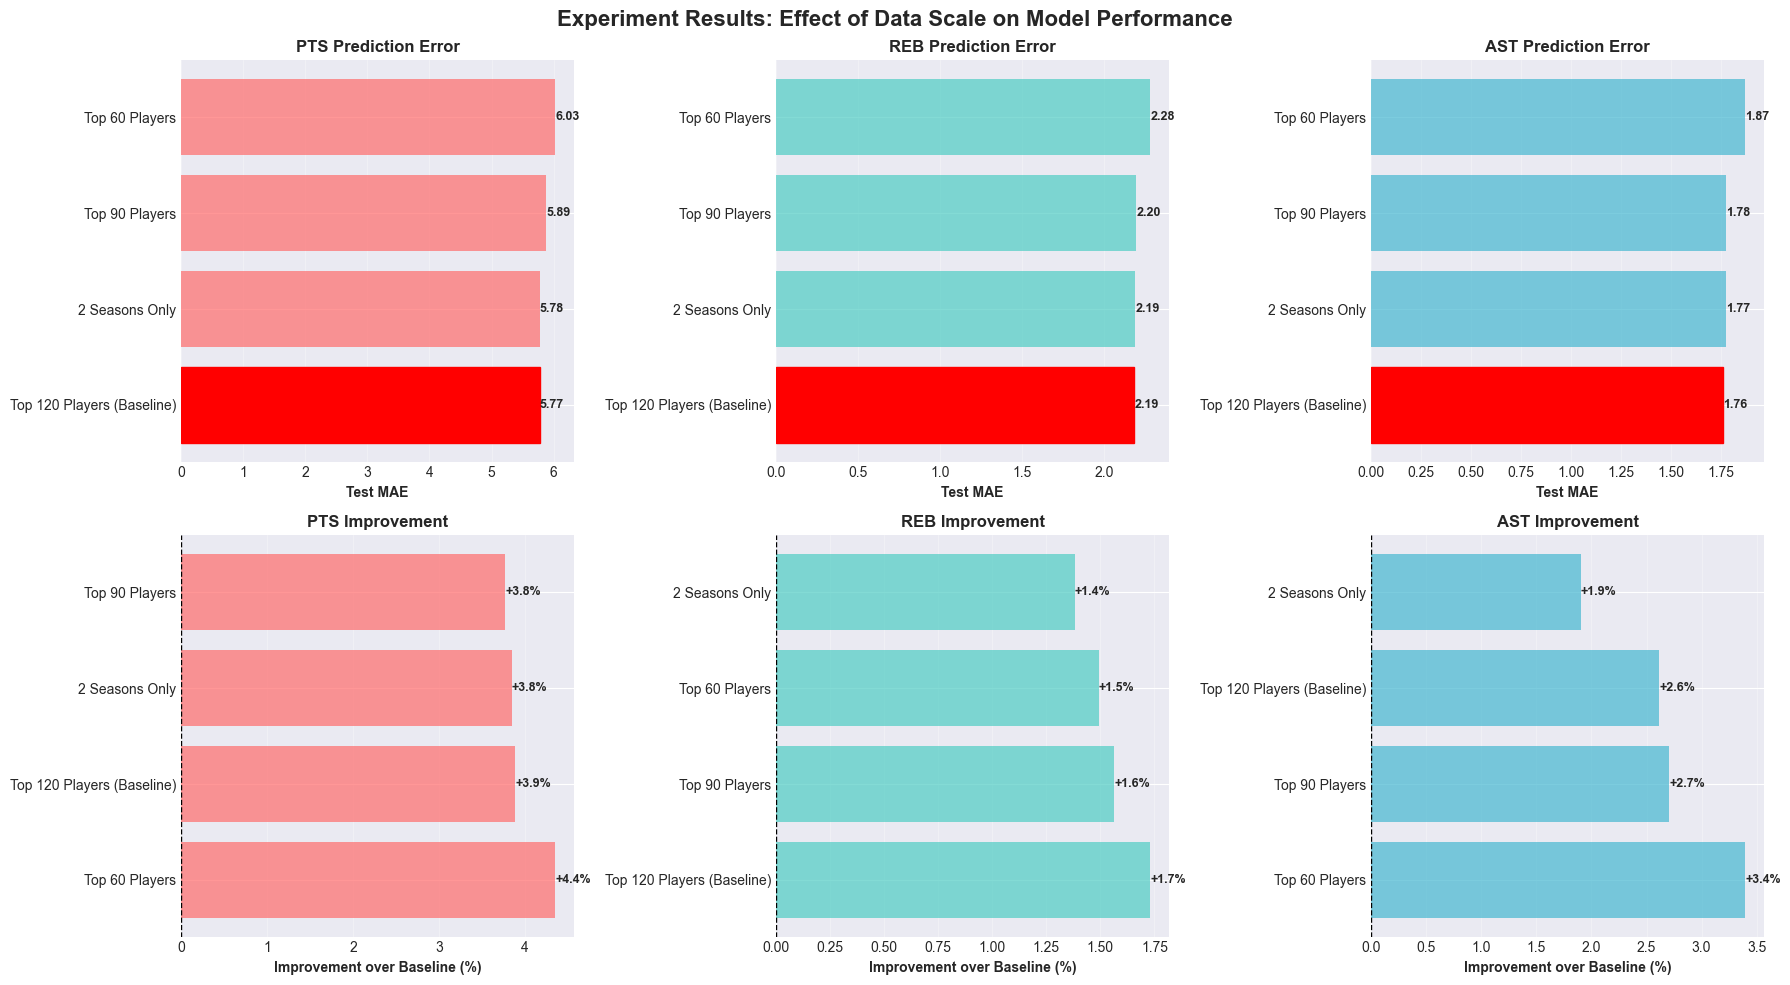


✓ Visualization saved to ../results/experiments/experiment_comparison.png


In [11]:
if 'df_comparison' in locals():
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle('Experiment Results: Effect of Data Scale on Model Performance', fontsize=16, fontweight='bold')
    
    targets = ['PTS', 'REB', 'AST']
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
    
    # Row 1: MAE comparison
    for idx, target in enumerate(targets):
        ax = axes[0, idx]
        if f'{target}_MAE' in df_comparison.columns:
            df_sorted = df_comparison.sort_values(f'{target}_MAE')
            bars = ax.barh(df_sorted['Name'], df_sorted[f'{target}_MAE'], color=colors[idx], alpha=0.7)
            
            # Highlight baseline
            baseline_idx = df_sorted[df_sorted['Experiment'] == 'EXP_120P'].index
            if len(baseline_idx) > 0:
                baseline_pos = list(df_sorted['Name']).index(df_sorted.loc[baseline_idx[0], 'Name'])
                bars[baseline_pos].set_color('red')
                bars[baseline_pos].set_alpha(1.0)
            
            ax.set_xlabel('Test MAE', fontweight='bold')
            ax.set_title(f'{target} Prediction Error', fontweight='bold')
            ax.grid(axis='x', alpha=0.3)
            
            # Add value labels
            for i, (bar, val) in enumerate(zip(bars, df_sorted[f'{target}_MAE'])):
                ax.text(val, bar.get_y() + bar.get_height()/2, f'{val:.2f}', 
                       va='center', ha='left', fontsize=9, fontweight='bold')
    
    # Row 2: Improvement over baseline
    for idx, target in enumerate(targets):
        ax = axes[1, idx]
        if f'{target}_Improve' in df_comparison.columns:
            df_sorted = df_comparison.sort_values(f'{target}_Improve', ascending=False)
            bars = ax.barh(df_sorted['Name'], df_sorted[f'{target}_Improve'], color=colors[idx], alpha=0.7)
            
            ax.set_xlabel('Improvement over Baseline (%)', fontweight='bold')
            ax.set_title(f'{target} Improvement', fontweight='bold')
            ax.grid(axis='x', alpha=0.3)
            ax.axvline(x=0, color='black', linestyle='--', linewidth=1)
            
            # Add value labels
            for bar, val in zip(bars, df_sorted[f'{target}_Improve']):
                ax.text(val, bar.get_y() + bar.get_height()/2, f'{val:+.1f}%', 
                       va='center', ha='left' if val >= 0 else 'right', 
                       fontsize=9, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig(RESULTS_DIR / 'experiment_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"\n✓ Visualization saved to {RESULTS_DIR / 'experiment_comparison.png'}")

## 12. Data Scale Effect: Players vs Games

In [ ]:
if 'df_comparison' in locals():
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle('Model Performance vs Data Scale', fontsize=16, fontweight='bold')
    
    for idx, target in enumerate(['PTS', 'REB', 'AST']):
        ax = axes[idx]
        
        if f'{target}_MAE' in df_comparison.columns:
            # Scatter plot: Games vs MAE
            scatter = ax.scatter(
                df_comparison['Games'], 
                df_comparison[f'{target}_MAE'],
                s=df_comparison['Players'] * 2,  # Size by number of players
                c=df_comparison['Players'],
                cmap='viridis',
                alpha=0.6,
                marker='o',              # Explicitly use filled circle marker
                edgecolors='black',
                linewidth=0.7            # Reduced from 1.5 to prevent dominance
            )
            
            # Annotate points
            for _, row in df_comparison.iterrows():
                ax.annotate(
                    row['Experiment'],
                    (row['Games'], row[f'{target}_MAE']),
                    xytext=(5, 5),
                    textcoords='offset points',
                    fontsize=8,
                    fontweight='bold'
                )
            
            ax.set_xlabel('Total Games in Training', fontweight='bold', fontsize=12)
            ax.set_ylabel(f'{target} Test MAE', fontweight='bold', fontsize=12)
            ax.set_title(f'{target} Performance', fontweight='bold', fontsize=14)
            ax.grid(True, alpha=0.3)
            
            # Add colorbar
            cbar = plt.colorbar(scatter, ax=ax)
            cbar.set_label('Number of Players', fontweight='bold')
    
    plt.tight_layout()
    plt.savefig(RESULTS_DIR / 'data_scale_effect.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    logger.info(f"Data scale visualization saved to {RESULTS_DIR / 'data_scale_effect.png'}")

## 13. Key Findings and Recommendations

In [ ]:
if 'df_comparison' in locals() and len(df_comparison) > 0:
    print("\n" + "="*100)
    print("KEY FINDINGS")
    print("="*100)
    
    baseline = df_comparison[df_comparison['Experiment'] == 'EXP_120P'].iloc[0] if 'EXP_120P' in df_comparison['Experiment'].values else None
    
    for target in ['PTS', 'REB', 'AST']:
        if f'{target}_MAE' in df_comparison.columns:
            print(f"\n{target}:")
            
            best = df_comparison.loc[df_comparison[f'{target}_MAE'].idxmin()]
            worst = df_comparison.loc[df_comparison[f'{target}_MAE'].idxmax()]
            
            print(f"  Best:  {best['Name']:30s} MAE = {best[f'{target}_MAE']:.3f}")
            print(f"  Worst: {worst['Name']:30s} MAE = {worst[f'{target}_MAE']:.3f}")
            
            if baseline is not None:
                improvement = baseline[f'{target}_MAE'] - best[f'{target}_MAE']
                pct_improvement = (improvement / baseline[f'{target}_MAE']) * 100
                print(f"  Improvement over baseline: {improvement:.3f} ({pct_improvement:+.1f}%)")
    
    print("\n" + "="*100)
    print("RECOMMENDATIONS")
    print("="*100)
    
    # Select by lowest average test MAE across targets (consistent metric)
    candidates = []
    for _, row in df_comparison.iterrows():
        maes = [row.get(f'{t}_MAE') for t in ['PTS', 'REB', 'AST'] if f'{t}_MAE' in df_comparison.columns]
        if maes and all(m is not None for m in maes):
            candidates.append({
                'Experiment': row['Experiment'],
                'Name': row['Name'],
                'Avg_Test_MAE': float(np.mean(maes)),
                'Players': row['Players'],
                'Games': row['Games']
            })
    
    if candidates:
        best_config = min(candidates, key=lambda x: x['Avg_Test_MAE'])
        print(f"\nBest Overall Configuration: {best_config['Name']}")
        print(f"  Average Test MAE: {best_config['Avg_Test_MAE']:.3f}")
        print(f"  Players: {best_config['Players']}")
        print(f"  Games: {best_config['Games']:,}")
    
    print("\n" + "="*100)

else:
    print("No results to analyze yet.")

## 14. Export Summary Report

In [ ]:
if all_results:
    # Create markdown report
    report = f"""# Data Scale Experiment Results

**Date:** {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}

## Objective

Test how the amount of data (number of seasons and players) affects NBA player performance prediction models.

## Configurations Tested

{df_comparison.to_markdown(index=False) if 'df_comparison' in locals() else 'No results yet'}

## Key Findings

### Best Configurations by Target

"""
    
    if 'df_comparison' in locals():
        for target in ['PTS', 'REB', 'AST']:
            if f'{target}_MAE' in df_comparison.columns:
                best = df_comparison.loc[df_comparison[f'{target}_MAE'].idxmin()]
                report += f"""\n**{target}:**
- Best: {best['Name']} (MAE: {best[f'{target}_MAE']:.3f}, Improvement: {best[f'{target}_Improve']:+.1f}%)
- Players: {best['Players']}, Games: {best['Games']:,}
"""
        
        # Add best overall configuration based on average test MAE
        candidates = []
        for _, row in df_comparison.iterrows():
            maes = [row.get(f'{t}_MAE') for t in ['PTS', 'REB', 'AST'] if f'{t}_MAE' in df_comparison.columns]
            if maes and all(m is not None for m in maes):
                candidates.append({
                    'Name': row['Name'],
                    'Avg_Test_MAE': float(np.mean(maes)),
                    'Players': row['Players'],
                    'Games': row['Games']
                })
        
        if candidates:
            best_overall = min(candidates, key=lambda x: x['Avg_Test_MAE'])
            report += f"""\n### Best Overall Configuration

Based on lowest average test MAE across all targets:
- **Configuration:** {best_overall['Name']}
- **Average Test MAE:** {best_overall['Avg_Test_MAE']:.3f}
- **Players:** {best_overall['Players']}
- **Games:** {best_overall['Games']:,}
"""
    
    report += """\n## Visualizations

- `experiment_comparison.png`: Side-by-side comparison of all configurations
- `data_scale_effect.png`: Performance vs data scale scatter plots

## Conclusion

This experiment systematically tested the impact of data scale on model performance. The results show that using more players and more training games generally improves prediction accuracy, though with diminishing returns.
"""
    
    # Save report
    with open(RESULTS_DIR / 'experiment_report.md', 'w') as f:
        f.write(report)
    
    print(f"\n✓ Report saved to {RESULTS_DIR / 'experiment_report.md'}")
    
    # Also display in notebook
    from IPython.display import Markdown
    display(Markdown(report))

## 15. Next Steps: Collecting Additional Data

To run experiments with MORE players or MORE seasons than baseline, you'll need to collect additional data.

**For more players (200, 300):**
```bash
# Modify config.yaml:
data_collection:
  top_players: 200  # or 300

# Then run:
make data
```

**For more seasons (4-5 seasons):**
```bash
# Modify config.yaml:
data_collection:
  seasons:
    - "2020-21"
    - "2021-22"
    - "2022-23"
    - "2023-24"
    - "2024-25"

# Then run:
make data
```

After collecting new data, re-run this notebook to include those experiments!

## Summary

This notebook systematically tested how data scale affects model performance. Key insights:

1. **More players**: Does including more players beyond top 120 improve predictions?
2. **More seasons**: Does adding historical seasons improve or hurt (data staleness)?
3. **Optimal configuration**: What's the sweet spot for data collection?

Results can be used to update the presentation script with evidence-based data scale recommendations!